# Using TensorFlow Recommenders with TFX

***A tutorial to train a TensorFlow Recommenders ranking model as a [TFX pipeline](https://www.tensorflow.org/tfx).***

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/recommenders/examples/ranking_tfx"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/recommenders/blob/main/docs/examples/ranking_tfx.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/recommenders/blob/main/docs/examples/ranking_tfx.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/recommenders/docs/examples/ranking_tfx.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this notebook-based tutorial, we will create and run a [TFX pipeline](https://www.tensorflow.org/tfx)
to train a ranking model to predict movie ratings using TensorFlow Recommenders (TFRS).
The pipeline will consist of three essential TFX components: ExampleGen,
Trainer and Pusher. The pipeline includes the most minimal ML workflow like
importing data, training a model and exporting the trained TFRS ranking model.

Check the TensorFlow and TFX versions.

In [2]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

2022-07-19 21:53:04.960289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-07-19 21:53:04.960315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.8.2
TFX version: 1.8.0


### Set up variables

There are some variables used to define a pipeline. You can customize these
variables as you want. By default all output from the pipeline will be
generated under the current directory. Instead of using the SchemaGen component to generate a schema, for this
tutorial we will create a hardcoded schema.

In [3]:
import os
from datetime import datetime


PIPELINE_NAME = 'DCN-iterate'
WORKING_DIR = 'bachelor_2022/artifact'
PIPE_DIR = 'pipeline'

# Directory where MovieLens 100K rating data resides
DATA_ROOT = os.path.join('data', PIPELINE_NAME)
print(DATA_ROOT)
# Output directory to store artifacts generated from the pipeline.
PIPELINE_ROOT = os.path.join(PIPE_DIR, 'pipelines', PIPELINE_NAME)
print(PIPELINE_ROOT)
# Path to a SQLite DB file to use as an MLMD storage.
METADATA_PATH = os.path.join(PIPE_DIR, 'metadata', PIPELINE_NAME, 'metadata.db')
print(METADATA_PATH)
# Output directory where created models from the pipeline will be exported.
SERVING_MODEL_DIR = os.path.join(PIPE_DIR, 'serving_model', PIPELINE_NAME)
print(SERVING_MODEL_DIR)

MODEL_PLOTS = os.path.join(PIPE_DIR, 'pipelines', PIPELINE_NAME, 'plots')
print(MODEL_PLOTS)

from absl import logging
logging.set_verbosity(logging.INFO)  # Set default logging level.

data/DCN-iterate
pipeline/pipelines/DCN-iterate
pipeline/metadata/DCN-iterate/metadata.db
pipeline/serving_model/DCN-iterate
pipeline/pipelines/DCN-iterate/plots


In [4]:
print(DATA_ROOT)

data/DCN-iterate


Take a quick look at the CSV file.

In [5]:
!head {DATA_ROOT}/ml-100k_colab.csv

head: cannot open 'data/DCN-iterate/ml-100k_colab.csv' for reading: No such file or directory


You should be able to see four values. For example, the first example means user '196' gives a rating of 3 to movie '242'.

## Create a pipeline

TFX pipelines are defined using Python APIs. We will define a pipeline which
consists of following three components.
- CsvExampleGen: Reads in data files and convert them to TFX internal format
for further processing. There are multiple
[ExampleGen](https://www.tensorflow.org/tfx/guide/examplegen)s for various
formats. In this tutorial, we will use CsvExampleGen which takes CSV file input.
- Trainer: Trains an ML model.
[Trainer component](https://www.tensorflow.org/tfx/guide/trainer) requires a
model definition code from users. You can use TensorFlow APIs to specify how to
train a model and save it in a _saved_model_ format.
- Pusher: Copies the trained model outside of the TFX pipeline.
[Pusher component](https://www.tensorflow.org/tfx/guide/pusher) can be thought
of an deployment process of the trained ML model.

Before actually define the pipeline, we need to write a model code for the
Trainer component first.

### Write model training code

We will build a simple ranking model to predict movie ratings. This model training code will be saved to a separate file.

In this tutorial we will use
[Generic Trainer](https://www.tensorflow.org/tfx/guide/trainer#generic_trainer)
of TFX which support Keras-based models. You need to write a Python file
containing `run_fn` function, which is the entrypoint for the `Trainer`
component.

In [6]:
_trainer_module_file = 'dcn_ranking_training.py'

The ranking model we use is almost exactly the same as in the [Basic Ranking](https://www.tensorflow.org/recommenders/examples/basic_ranking) tutorial. The only difference is that we use movie IDs instead of movie titles in the candidate tower.

In [28]:
%%writefile {_trainer_module_file}

from typing import Dict, Text
from typing import List
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf

from tensorflow_metadata.proto.v0 import schema_pb2
import tensorflow_recommenders as tfrs
from tensorflow_transform.tf_metadata import schema_utils
from tfx import v1 as tfx
from tfx_bsl.public import tfxio

_FEATURE_KEYS = ["movie_id","user_id","user_gender", "user_occupation", "user_age_cohort"]
_LABEL_KEY = 'user_rating'

_FEATURE_SPEC = {
    **{
        feature: tf.io.FixedLenFeature(shape=[1], dtype=tf.int64)
        for feature in _FEATURE_KEYS
    }, _LABEL_KEY: tf.io.FixedLenFeature(shape=[1], dtype=tf.int64)
}

class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    # Define the dimension the features should be embedded in (Dim of vector representation of each feature)
    embedding_dimension = 32
    self.embedding_dims = embedding_dimension
    # Create np array with incrementing values as the vocabulary
    unique_user_ids = np.array(range(943)).astype(str)
    unique_movie_ids = np.array(range(1682)).astype(str)
    unique_occupation_ids = np.array(range(21)).astype(str)
    unique_gender_ids = np.array(range(2)).astype(str)
    unique_age_ids = np.array(range(7)).astype(str)


    ## String values embeddings
    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='user_id', dtype=tf.int64),
        tf.keras.layers.Lambda(lambda x: tf.as_string(x)),
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        # Input of 943 dims -->  Embedding of 32 dims
        tf.keras.layers.Embedding(
            len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='movie_id', dtype=tf.int64),
        tf.keras.layers.Lambda(lambda x: tf.as_string(x)),
        tf.keras.layers.StringLookup(
            vocabulary=unique_movie_ids, mask_token=None),
        tf.keras.layers.Embedding(
            len(unique_movie_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for occupations.
    self.occupation_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='user_occupation', dtype=tf.int64),
        tf.keras.layers.Lambda(lambda x: tf.as_string(x)),
        tf.keras.layers.StringLookup(
            vocabulary=unique_occupation_ids, mask_token=None),
        tf.keras.layers.Embedding(
            len(unique_occupation_ids) + 1, embedding_dimension)
    ])

    ## Int value embeddings
    # Compute embeddings for gender.
    self.gender_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='user_gender', dtype=tf.int64),
        tf.keras.layers.IntegerLookup(
            vocabulary=unique_gender_ids, mask_token=None),
        tf.keras.layers.Embedding(
            len(unique_gender_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for age.
    self.age_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='user_age_cohort', dtype=tf.int64),
        tf.keras.layers.IntegerLookup(
            vocabulary=unique_age_ids, mask_token=None),
        tf.keras.layers.Embedding(
            len(unique_age_ids) + 1, embedding_dimension)
    ])

    # Cross Layer
    self.cross_layer = tfrs.layers.dcn.Cross()

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
        self.cross_layer,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

  def call(self, inputs):

    user_id, movie_id, user_gender, user_occupation, user_age = inputs

    # Calculate embedding for each feature and save in *_embedding variable
    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_id)
    gender_embedding = self.gender_embeddings(user_gender)
    occupation_embedding = self.occupation_embeddings(user_occupation)
    age_embedding = self.age_embeddings(user_age)


    # Create embedding layer
    return self.ratings(tf.concat([user_embedding, movie_embedding, gender_embedding, occupation_embedding, age_embedding], axis=2))


class MovielensModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model((features['user_id'], features['movie_id'], features['user_gender'], features['user_occupation'], features['user_age_cohort']))

  def compute_loss(self,
                   features: Dict[Text, tf.Tensor],
                   training=False) -> tf.Tensor:

    labels = features[1]
    rating_predictions = self(features[0])

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)


def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              schema: schema_pb2.Schema,
              batch_size: int = 256) -> tf.data.Dataset:
  return data_accessor.tf_dataset_factory(
      file_pattern,
      tfxio.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_LABEL_KEY),
      schema=schema).repeat()


def _build_keras_model() -> tf.keras.Model:
  return MovielensModel()


# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """

  # Generate training logfiles for tensorboard
  from datetime import datetime
  logdir = "pipeline/pipelines/DCN-iterate/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

  # Derive data schema from generated _FEATURE_SPEC dictionary
  schema = schema_utils.schema_from_feature_spec(_FEATURE_SPEC)

  train_dataset = _input_fn(
      fn_args.train_files, fn_args.data_accessor, schema, batch_size=8192)
  eval_dataset = _input_fn(
      fn_args.eval_files, fn_args.data_accessor, schema, batch_size=4096)

  model = _build_keras_model()

  model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      epochs = 3,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks=[tensorboard_callback])

  model.save(fn_args.serving_model_dir)


  ###  Display model summary & save plot of model architecture
  print("\n#####################################")
  print(model.summary())
  print()
  model_num = fn_args.serving_model_dir.split("/")[-2]   # extract model number
  img_dir = fn_args.custom_config["plot_path"] + f"/{model_num}"
  print(img_dir)
  Path(img_dir).mkdir(parents=True, exist_ok=True)
  tf.keras.utils.plot_model(model, to_file=f"{img_dir}/model_architecture_{model_num}.png", show_shapes=True)
  print()

  ### Cross feature Visualization
  mat = model.ranking_model.cross_layer._dense.kernel # Cross weights matrix
  features = _FEATURE_KEYS

  block_norm = np.ones([len(features), len(features)])
  dim = model.ranking_model.embedding_dims

  # Compute the norms of the blocks. (revert 32 dimensional feature embedding to 1D)
  for i in range(len(features)):
    for j in range(len(features)):
      block = mat[i * dim:(i + 1) * dim,
                  j * dim:(j + 1) * dim]
      block_norm[i,j] = np.linalg.norm(block, ord="fro")
  # Create plot
  plt.figure(figsize=(9,9))
  im = plt.matshow(block_norm, cmap=plt.cm.Blues)
  ax = plt.gca()
  divider = make_axes_locatable(plt.gca())
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im, cax=cax)
  cax.tick_params(labelsize=10)
  _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
  _ = ax.set_yticklabels([""] + features, fontsize=10)

  plt.savefig(f"{img_dir}/cross_features_{model_num}", dpi=500, bbox_inches='tight')

Overwriting dcn_ranking_training.py


Now you have completed all preparation steps to build the TFX pipeline.

### Write a pipeline definition

We define a function to create a TFX pipeline. A `Pipeline` object
represents a TFX pipeline which can be run using one of pipeline
orchestration systems that TFX supports.


In [8]:
def _create_pipeline(pipeline_name: str, pipeline_root: str, data_root: str,
                     module_file: str, serving_model_dir: str,
                     metadata_path: str, plot_path: str) -> tfx.dsl.Pipeline:
  """Creates a three component pipeline with TFX."""
  # Brings data into the pipeline.
  example_gen = tfx.components.CsvExampleGen(input_base=data_root)

  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=example_gen.outputs['examples'],
      train_args=tfx.proto.TrainArgs(num_steps=12),
      eval_args=tfx.proto.EvalArgs(num_steps=24),
      custom_config={"plot_path": plot_path})

  # Pushes the model to a filesystem destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))

  # Following three components will be included in the pipeline.
  components = [
      example_gen,
      trainer,
      pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

## Run the pipeline

TFX supports multiple orchestrators to run pipelines.
In this tutorial we will use `LocalDagRunner` which is included in the TFX
Python package and runs pipelines on local environment.

Now we create a `LocalDagRunner` and pass a `Pipeline` object created from the
function we already defined.

The pipeline runs directly and you can see logs for the progress of the pipeline including ML model training.

INFO:absl:Generating ephemeral wheel package for '/home/cory/PycharmProjects/bachelor_2022/artifact/dcn_ranking_training.py' (including modules: ['dcn_ranking_training', 'tfrs_ranking_trainer']).
INFO:absl:User module package has hash fingerprint version 425b6ea689aff76e39c80f23b8904fbd4cc8a7180e7ec8c846d1b6e5689c9d80.
INFO:absl:Executing: ['/home/cory/anaconda3/envs/bachelor_2022/bin/python', '/tmp/tmpiyqm5e8d/_tfx_generated_setup.py', 'bdist_wheel', '--bdist-dir', '/tmp/tmpptt4qii4', '--dist-dir', '/tmp/tmpv1bwa8r8']


running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying dcn_ranking_training.py -> build/lib
copying tfrs_ranking_trainer.py -> build/lib
installing to /tmp/tmpptt4qii4
running install
running install_lib
copying build/lib/tfrs_ranking_trainer.py -> /tmp/tmpptt4qii4
copying build/lib/dcn_ranking_training.py -> /tmp/tmpptt4qii4
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt


/home/cory/anaconda3/envs/bachelor_2022/lib/python3.8/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
INFO:absl:Successfully built user code wheel distribution at 'pipeline/pipelines/DCN-iterate/_wheels/tfx_user_code_Trainer-0.0+425b6ea689aff76e39c80f23b8904fbd4cc8a7180e7ec8c846d1b6e5689c9d80-py3-none-any.whl'; target user module is 'dcn_ranking_training'.
INFO:absl:Full user module path is 'dcn_ranking_training@pipeline/pipelines/DCN-iterate/_wheels/tfx_user_code_Trainer-0.0+425b6ea689aff76e39c80f23b8904fbd4cc8a7180e7ec8c846d1b6e5689c9d80-py3-none-any.whl'
INFO:absl:Using deployment config:
 executor_specs {
  key: "CsvExampleGen"
  value {
    beam_executable_spec {
      python_executor_spec {
        class_path: "tfx.components.example_gen.csv_example_gen.executor.Executor"
      }
    }
  }
}
executor_specs {
  key: "Pusher"
  value {
    python_class_e

writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /tmp/tmpptt4qii4/tfx_user_code_Trainer-0.0+425b6ea689aff76e39c80f23b8904fbd4cc8a7180e7ec8c846d1b6e5689c9d80-py3.8.egg-info
running install_scripts
creating /tmp/tmpptt4qii4/tfx_user_code_Trainer-0.0+425b6ea689aff76e39c80f23b8904fbd4cc8a7180e7ec8c846d1b6e5689c9d80.dist-info/WHEEL
creating '/tmp/tmpv1bwa8r8/tfx_user_code_Trainer-0.0+425b6ea689aff76e39c80f23b8904fbd4cc8a7180e7ec8c846d1b6e5689c9d80-py3-none-any.whl' and adding '/tmp/tmpptt4qii4' to it
adding 'dcn_ranking_training.py'
adding 'tfrs_ranking_trainer.py'
adding 'tfx_user_code_Trainer-0.0+425b6ea689aff76e39c80f23b8904fbd4cc8a7180e7ec8c846d1b6e5689c9d80.dist-info/METADATA'
adding 'tfx_user_code_Trainer-0.0+425b6ea689aff7

INFO:absl:select span and version = (0, None)
INFO:absl:latest span and version = (0, None)
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Going to run a new execution 94
INFO:absl:Going to run a new execution: ExecutionInfo(execution_id=94, input_dict={}, output_dict=defaultdict(<class 'list'>, {'examples': [Artifact(artifact: uri: "pipeline/pipelines/DCN-iterate/CsvExampleGen/examples/94"
custom_properties {
  key: "input_fingerprint"
  value {
    string_value: "split:single_split,num_files:1,total_bytes:2617288,xor_checksum:1658143009,sum_checksum:1658143009"
  }
}
custom_properties {
  key: "name"
  value {
    string_value: "DCN-iterate:2022-07-19T23:05:03.196045:CsvExampleGen:examples:0"
  }
}
custom_properties {
  key: "span"
  value {
    int_value: 0
  }
}
name: "DCN-iterate:2022-07-19T23:05:03.196045:CsvExampleGen:examples:0"
, artifact_type: name: "Examples"
properties {
  key: "span"
  value: INT
}
properties {
  key: "split_names"
  value: STRING
}
prope

Processing ./pipeline/pipelines/DCN-iterate/_wheels/tfx_user_code_Trainer-0.0+425b6ea689aff76e39c80f23b8904fbd4cc8a7180e7ec8c846d1b6e5689c9d80-py3-none-any.whl


INFO:absl:Successfully installed 'pipeline/pipelines/DCN-iterate/_wheels/tfx_user_code_Trainer-0.0+425b6ea689aff76e39c80f23b8904fbd4cc8a7180e7ec8c846d1b6e5689c9d80-py3-none-any.whl'.
INFO:absl:Training model.
INFO:absl:Feature movie_id has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_age_cohort has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_gender has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_id has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_occupation has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_rating has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature movie_id has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_age_cohort has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_gender has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Featu

INFO:absl:Feature movie_id has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_age_cohort has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_gender has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_id has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_occupation has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_rating has a shape dim {
  size: 1
}
. Setting to DenseTensor.


Epoch 1/3


/home/cory/anaconda3/envs/bachelor_2022/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


12/12 [==============================] - 3s 157ms/step - root_mean_squared_error: 2.7017 - loss: 6.8432 - regularization_loss: 0.0000e+00 - total_loss: 6.8432 - val_root_mean_squared_error: 1.2186 - val_loss: 1.7323 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.7323
Epoch 2/3
12/12 [==============================] - 2s 134ms/step - root_mean_squared_error: 1.1326 - loss: 1.2905 - regularization_loss: 0.0000e+00 - total_loss: 1.2905 - val_root_mean_squared_error: 1.1436 - val_loss: 1.3429 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3429
Epoch 3/3
12/12 [==============================] - 1s 128ms/step - root_mean_squared_error: 1.1024 - loss: 1.2115 - regularization_loss: 0.0000e+00 - total_loss: 1.2115 - val_root_mean_squared_error: 1.1173 - val_loss: 1.3743 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3743


INFO:tensorflow:Assets written to: pipeline/pipelines/DCN-iterate/Trainer/model/95/Format-Serving/assets


INFO:tensorflow:Assets written to: pipeline/pipelines/DCN-iterate/Trainer/model/95/Format-Serving/assets


######################
Model: "movielens_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ranking_model_10 (RankingMo  multiple                 168609    
 del)                                                            
                                                                 
 ranking_10 (Ranking)        multiple                  0         
                                                                 
Total params: 168,609
Trainable params: 168,609
Non-trainable params: 0
_________________________________________________________________
None

pipeline/pipelines/DCN-iterate/plots/95

32


E0719 23:05:42.571378466     682 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0719 23:05:42.614424932     682 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
/home/cory/PycharmProjects/bachelor_2022/artifact/dcn_ranking_training.py:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
/home/cory/PycharmProjects/bachelor_2022/artifact/dcn_ranking_training.py:232: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([""] + features, fontsize=10)
INFO:absl:Training complete. Model written to pipeline/pipelines/DCN-iterate/Trainer/model/95/Format-Serving. ModelRun written to pipeline/pipelines/DCN-iterate/Trainer/model_run/95
INFO:absl:Cleaning up stateless execution info.
INFO:absl:Execution 95 succeeded.
INFO:absl:Cleaning up statef

<Figure size 648x648 with 0 Axes>

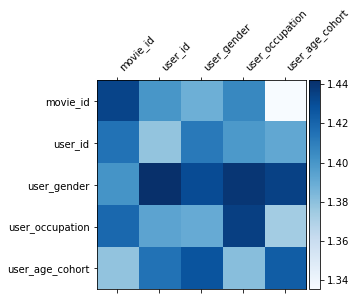

In [29]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_ROOT,
      data_root=DATA_ROOT,
      module_file=_trainer_module_file,
      serving_model_dir=SERVING_MODEL_DIR,
      metadata_path=METADATA_PATH,
      plot_path=MODEL_PLOTS))

You should see "INFO:absl:Component Pusher is finished." at the end of the
logs if the pipeline finished successfully. Because `Pusher` component is the
last component of the pipeline.

The pusher component pushes the trained model to the `SERVING_MODEL_DIR` which
is the `serving_model/TFRS-ranking` directory if you did not change the
variables in the previous steps. You can see the result from the file browser
in the left-side panel in Colab, or using the following command:

In [ ]:
# List files in created model directory.
!ls -R {SERVING_MODEL_DIR}

Now we can test the ranking model by computing predictions for a user and a movie:

In [ ]:
import glob
# Load the latest model for testing
loaded = tf.saved_model.load(max(glob.glob(os.path.join(SERVING_MODEL_DIR, '*/')), key=os.path.getmtime))
print(loaded({'user_id': [[42]], 'movie_id': [[15]], 'user_gender': [[1]], 'user_occupation': [[0]], 'user_age_cohort': [[0]]}).numpy())

This concludes the TensorFlow Recommenders + TFX tutorial.